In [1]:
import os
from dotenv import load_dotenv



# Load environment variables
# load_dotenv()


# Set OpenAI API Key
# os.environ["OPENAI_API_KEY"]

Prompts for System behaviour



In [77]:
### Contextualize question ###
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)


# Define the system prompt template
system_prompt = r"""
You are a helpful AI assistant that knows about Ulster or Ulster University based on the context provided. 

Assume all user questions are about ulster university and if you have information closely related to question asked, provide the answer.

Keep all responses short and adequate, providing enough information to answer the question without unnecessary details.

# Safety
If you feel like you do not have enough information to answer the question about ulster university, say "Can you provide more context".

If there are any questions about something other than ulster university. Kindly decline to respond

Do not forget. You only use the provided context to answer questions about ulster or ulster university.

----
{context}
----

"""

In [78]:
from PyPDF2 import PdfReader
import requests
import io

# Function to extract text from PDF documents
def extract_text_from_pdf(pdf_docs):
    text = ""
    try:
        for pdf in pdf_docs:
            # If it's a URL, download the PDF first
            if pdf.startswith('http'):
                response = requests.get(pdf)
                pdf_file = io.BytesIO(response.content)
            else:
                pdf_file = pdf
            pdf_reader = PdfReader(pdf_file)
            for page in pdf_reader.pages:
                text += page.extract_text()
    except Exception as e:
        print(f"Error processing PDF: {str(e)}")
        return None
    return text

In [79]:
url = ['ulster_data.pdf']
text = extract_text_from_pdf(url)

In [80]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from configs.config import MODEL_NAME, TEMPERATURE, CHUNK_SIZE, CHUNK_OVERLAP



# Function to split text into chunks
def get_text_chunks(pdf_text):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP,
        length_function=len,
        separators=["\n\n", "\n", ".", " ", ""]
    )
    chunks = text_splitter.split_text(pdf_text)

    return chunks

In [81]:
chunks = get_text_chunks(text)

# print(chunks[0])

In [82]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS


def create_vectorstore(text_chunks):
    vectorstore = FAISS.from_texts(
        texts=text_chunks, embedding=OpenAIEmbeddings()
    )

    return vectorstore


In [83]:
create_vector = create_vectorstore(chunks)

In [86]:
import json

with open('eval.json', 'r') as file:
    data = json.load(file)

# print(data[30])

In [1]:
# data[10]

In [88]:
from configs.config import MODEL_NAME, TEMPERATURE
from langchain_core.prompts import MessagesPlaceholder, ChatPromptTemplate
from langchain.chains.retrieval import create_retrieval_chain
from langchain.chains.history_aware_retriever import create_history_aware_retriever
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.messages import AIMessage, HumanMessage


def create_conversation_chain(vectorstore):

    llm = ChatOpenAI(
        temperature=TEMPERATURE,
        model="gpt-4o-mini",
    )

    contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
    )
    
    history_aware_retriever = create_history_aware_retriever(
        llm,
        vectorstore.as_retriever(),
        contextualize_q_prompt,
    )

    qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
    )

    question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

    rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

    return rag_chain


In [ ]:
from tqdm.auto import tqdm

rag = create_conversation_chain(create_vector)
# ques = ['Is AI course available?', "What is the fee?"]
results = []
contexts = []
hist = []

for que in tqdm(data):
    res = rag.invoke({"input": que['question'], "chat_history": hist})
    res['chat_history'].extend(
        [
            HumanMessage(content=res['input']),
            AIMessage(content=res['answer']),

        ]
    )
    results.append(res['answer'])
    contents = ' '.join(doc.page_content for doc in res['context'])
    contexts.append(contents)
    
    hist = res['chat_history']

In [92]:
# contexts

In [97]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    context_entity_recall, 
    answer_similarity, 
    answer_correctness
)
from ragas.metrics.critique import harmfulness
from datasets import Dataset

In [113]:
# len(contexts)
contexts = [[context] if isinstance(context, str) else context for context in contexts]

In [114]:
# from sklearn import metrics
# from sklearn.metrics import f1_score


d = {
    "question": [dic['question'] for dic in data],
    "answer": results,
    "contexts": contexts,
    "ground_truth": [dic['reference_answer'] for dic in data],
}

dataset = Dataset.from_dict(d)



In [ ]:
dataset

In [ ]:
score = evaluate(dataset, metrics=[faithfulness, answer_relevancy, context_precision, context_recall, context_entity_recall, answer_similarity, answer_correctness, harmfulness])

In [118]:
score_df = score.to_pandas()
score_df.to_csv("evaluation_scores.csv", encoding="utf-8", index=False)

In [ ]:
score_df[['faithfulness','answer_relevancy', 'context_precision', 'context_recall',
    'context_entity_recall', 'answer_similarity', 'answer_correctness',
    'harmfulness']].mean(axis=0)

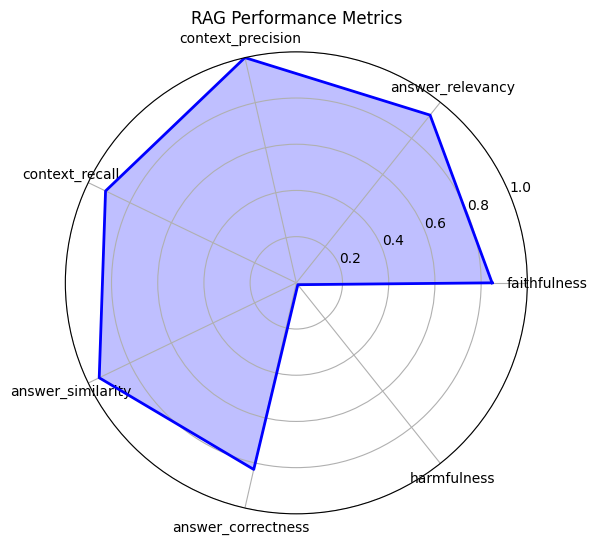

In [3]:
import numpy as np
import matplotlib.pyplot as plt


scores = {
    "faithfulness": 0.847508,
    "answer_relevancy": 0.928688,
    "context_precision": 1.000000,
    "context_recall": 0.916667,
    "answer_similarity": 0.947127,
    "answer_correctness": 0.828523,
    "harmfulness": 0.010345
}

labels = list(scores.keys())
values = list(scores.values())

# Number of variables
num_vars = len(labels)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Complete the loop
values += values[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

ax.fill(angles, values, color='blue', alpha=0.25)
ax.plot(angles, values, color='blue', linewidth=2)

ax.set(xticks=angles[:-1], xticklabels=labels, yticks=[0.2, 0.4, 0.6, 0.8, 1.0], ylim=(0, 1))

plt.title('RAG Performance Metrics')
plt.show()


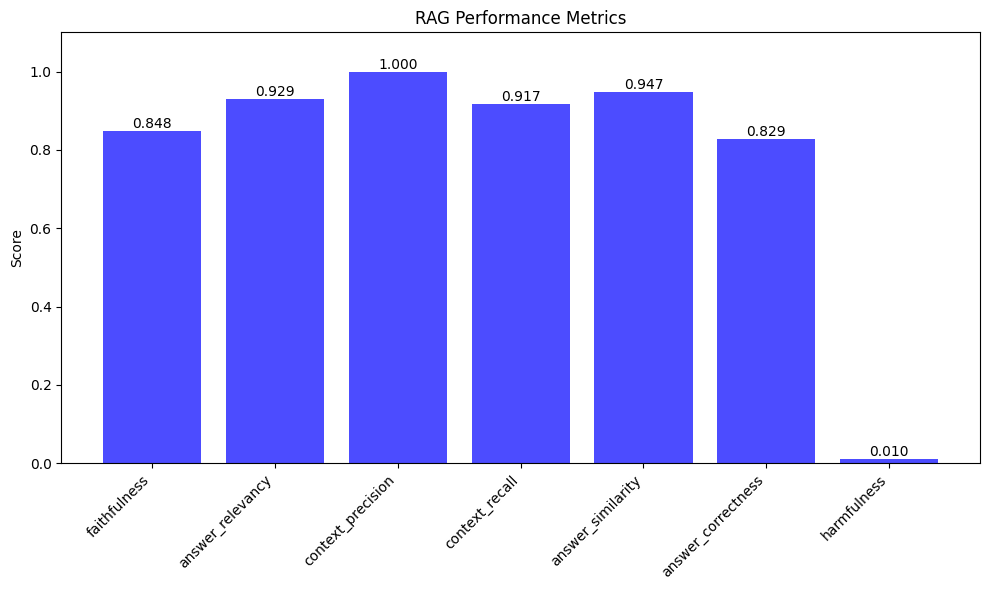

In [1]:
import matplotlib.pyplot as plt

scores = {
    "faithfulness": 0.847508,
    "answer_relevancy": 0.928688,
    "context_precision": 1.000000,
    "context_recall": 0.916667,
    "answer_similarity": 0.947127,
    "answer_correctness": 0.828523,
    "harmfulness": 0.010345
}

labels = list(scores.keys())
values = list(scores.values())

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(labels, values, color='blue', alpha=0.7)

ax.set_ylabel('Score')
ax.set_title('RAG Performance Metrics')
ax.set_ylim(0, 1.1)  # Set y-axis limit from 0 to 1.1 for better visibility

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom')

plt.tight_layout()
plt.show()